In [24]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks.

TRAIN_DIR = r'E:\SHU\10901\AI Introduction\Final project\input\Kaggle_Data\train'

TEST_DIR = input("Please input the direction of TEST DATA (if need to use the default file, type 'DEFAULT'): ")

if TEST_DIR == 'DEFAULT':
    TEST_DIR = r'E:\SHU\10901\AI Introduction\Final project\input\Kaggle_Data\test' 
else:
    TEST_DIR = TEST_DIR
    
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'animals_recognize-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

Please input the direction of TEST DATA (if need to use the default file, type 'DEFAULT'): E:\SHU\10901\AI Introduction\Final project\input\coustomDIR
E:\SHU\10901\AI Introduction\Final project\input\coustomDIR


In [25]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return          [1,0,0,0,0,0,0,0,0,0]
    elif word_label == 'dog': return        [0,1,0,0,0,0,0,0,0,0]
    elif word_label == 'Horse': return      [0,0,1,0,0,0,0,0,0,0]
    elif word_label == 'Chicken': return    [0,0,0,1,0,0,0,0,0,0]
    elif word_label == 'Cow': return        [0,0,0,0,1,0,0,0,0,0]
    elif word_label == 'Elefante': return   [0,0,0,0,0,1,0,0,0,0]
    elif word_label == 'Butterfly': return  [0,0,0,0,0,0,1,0,0,0]
    elif word_label == 'Sheep': return      [0,0,0,0,0,0,0,1,0,0]
    elif word_label == 'Spyder': return     [0,0,0,0,0,0,0,0,1,0]
    elif word_label == 'Squirrel': return   [0,0,0,0,0,0,0,0,0,1]

In [26]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
        
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [27]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [9]:
# train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy', allow_pickle=True)

In [10]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.compat.v1.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 10, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\User\code\animals_recognize-0.001-2conv-basic.model
model loaded!


In [14]:
train = train_data[:-1000]
test = train_data[-1000:]

In [15]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [16]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 25084  | total loss: 0.42302 | time: 58.253s
| Adam | epoch: 003 | loss: 0.42302 - acc: 0.8630 -- iter: 43584/43648
Training Step: 25085  | total loss: 0.41461 | time: 59.333s
| Adam | epoch: 003 | loss: 0.41461 - acc: 0.8642 | val_loss: 0.49608 - val_acc: 0.8280 -- iter: 43648/43648
--


In [17]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\User\code\animals_recognize-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.31it/s]

['01.jpg']



C:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


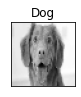

In [28]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
# test_data = np.load('test_data.npy', allow_pickle=True)

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 0: str_label='Cat'
    elif np.argmax(model_out) == 1: str_label='Dog'
    elif np.argmax(model_out) == 2: str_label='Horse'
    elif np.argmax(model_out) == 3: str_label='Chicken'
    elif np.argmax(model_out) == 4: str_label='Cow'
    elif np.argmax(model_out) == 5: str_label='Elefante'
    elif np.argmax(model_out) == 6: str_label='Butterfly'
    elif np.argmax(model_out) == 7: str_label='Sheep'
    elif np.argmax(model_out) == 8: str_label='Spyder'
    elif np.argmax(model_out) == 9: str_label='Squirrel'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [53]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 32148/32148 [00:35<00:00, 901.48it/s]
